<a href="https://colab.research.google.com/github/tommyarmstrong/WhatsAppAnalysis/blob/main/WhatsAppAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
import datetime as dt
from seaborn import *
from seaborn import heatmap as heatmap
from wordcloud import WordCloud , STOPWORDS , ImageColorGenerator
from nltk import *
from plotly import express as px
!pip install emoji
import emoji
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [158]:
from importlib import reload
plt=reload(plt)

In [159]:
# Define functions to use in the data gathering and engineering

def starts_with_datetime(s):
  """
  Check that a string starts with a date and time in the standard format
  """
  pattern = '^([[0-9][0-9]+)(/)([0-9][0-9]+)(/)([0-9][0-9][0-9][0-9]), ([0-9][0-9]+):([0-9][0-9]+):([0-9][0-9])'
  result = re.match(pattern, s)
  if result:
    return True
  return False

def contains_name(s):
  """
  Check that a string begins with a person's name or 
  phone number and a semicolon
  """
  patterns = [
        '(\w+):',                    # First Name
        '(\w+\s+\w+):',              # First Name + Last Name
        '(\w+\s+\w+\s+\w+):',        # First Name + Middle Name + Last Name
        '([\u202a][+]\d{2}[\xa0]\d{4}[\xa0]\d{6}[\u202c][:])'   # Mobile Number (UK) (including unicode)
        # '([w]+)[u263a-U0001f999]+:',  # Name and Emoji              
  ]
  pattern = '^' + '|'.join(patterns)
  result = re.match(pattern, s)
  if result:
    return True
  return False

def seperate_data_in_string(line): 
  """
  Split a line from a WhatsApp export file, pased as a string, into date, time, 
  author and message components. Then return the components.
  """ 
  line = line[1:]                     # Strip leading '[' from the string
  split_line = line.split('] ')       # Split on the first ']' character
  date_time = split_line[0]
  date, time = date_time.split(', ')  # Split date and time on the ',' seperator
  message = ''.join(split_line[1:])
  if contains_name(message):          # Confirm message begins with an author name
    split_message = message.split(':')  # Split the name from the message
    author = split_message[0] 
    message = ' '.join(split_message[1:])
  else: 
    author = None
  return date, time, author, message

def parse_whatsapp_export(fp):
  """ 
  Read a WhatsApp export file passed as an open file handle.
  Parse each line of text in the file.
  Call a funtion to seperate each line on the export into date, time, person 
  and message components and append them to rows of a Pandas dataframe. 
  Return the dataframe.
  """  
  parsed_data = []
  message_buffer = [] 
  date, time, person = None, None, None    
  while True:
    line = fp.readline() 
    if not line: 
      break
    line = line.strip() 
    if starts_with_datetime(line): 
      if len(message_buffer) > 0: 
        parsed_data.append([date, time, person, ''.join(message_buffer)]) 
      message_buffer.clear() 
      date, time, person, message = seperate_data_in_string(line) 
      message_buffer.append(message.strip())
    else:
      message_buffer.append(line)
  df = pd.DataFrame(parsed_data, columns=['date', 'time', 'person', 'message'])
  return df

def load_whatsapp_export(file_name):
  """
  Open the WhatsApp export file from Google Drive and return the file
  """

  from pathlib import Path
  from google.colab import drive

  drive.mount('/content/drive', force_remount=True)
  file_path = '/content/drive/MyDrive/Data Sets'
  file_path = file_path + '/' + chat_file_name

  if Path(file_path).is_file():
    print(f"Data exists in Google Drive.\nImporting from:\n{file_path}.")
    with open(file_path, encoding="utf-8") as fp:
      df = parse_whatsapp_export(fp)
      return df
  else:
    print(f"Data DOES NOT exist in Google Drive.")
    return pd.DataFrame()

def average_sentiment_scores(df):
  x1 = df["nltk_positive"].mean()
  x2 = df["nltk_negative"].mean()
  x3 = df["nltk_neutral"].mean()
  x4 = df["nltk_compound"].mean()
  sentiment_headline(x4)
  print(f'\tcompound: {round(x4*100, 1)}%')
  print(f'\tpositive: {round(x1*100, 1)}%')
  print(f'\tnegative: {round(x2*100, 1)}%')
  print(f'\tneutral:  {round(x3*100, 1)}%')

def sentiment_headline(compound):
    if compound > 0.05:
        print('Sentiment: Positive')
    elif compound > -0.05:
        print('Sentiment: Neutral')
    else:
        print('Sentiment: Negative')


In [160]:
# Configure the filename for the WhatsApp export file
#chat_name = 'Glenwood Road Residents'
chat_name = 'Antoniooooo'
#chat_name = 'Grecian 3000'

chat_file_name = 'WhatsApp Chat - ' + chat_name + '.txt'

# Create a dataframe from WhatsApp messages for analysis
df = load_whatsapp_export(chat_file_name)


df.head()

Mounted at /content/drive
Data exists in Google Drive.
Importing from:
/content/drive/MyDrive/Data Sets/WhatsApp Chat - Antoniooooo.txt.


,date,time,person,message
0,13/07/2016,19:10:05,None,‎Alex Renton created this group
1,13/07/2016,19:32:42,None,‎Alex Renton added you
2,13/07/2016,19:33:08,Alex Renton,Don't know how i couldn't find that earlier
3,13/07/2016,19:57:02,Alex Renton,Apparently the best bit is blocks 132 to 136
4,13/07/2016,20:03:21,Andy Spurs,I love it long


In [161]:
df.shape

(29589, 4)

In [162]:
# Create a datatime column
df["date_time"] = pd.to_datetime(df["date"], dayfirst=True)

In [163]:
# View the contributions by person
df.groupby('person').count()

,date,time,message,date_time
person,,,,
AJ Pollington,86,86,86,86
Alex Renton,6899,6899,6899,6899
Andy Spurs,1740,1740,1740,1740
Andy Tipping,2265,2265,2265,2265
Antoniooooo,1,1,1,1
Ben Spurs,1073,1073,1073,1073
Chris Allen,162,162,162,162
Dan Dobson,570,570,570,570
Dave Spurs,1287,1287,1287,1287


In [164]:
# Remove the system message
df = df[df.person != chat_name]

In [165]:
# View NANs
df.isnull().sum()

date          0
time          0
person       61
message       0
date_time     0
dtype: int64

In [166]:
# Remove the NaN rows. These are private key change notifications
df = df.dropna()
df.shape

(29527, 5)

In [167]:
# Count number of letters in each message
df['characters'] = df['message'].apply(lambda s : len(s))

# Count number of word's in each message
df['words'] = df['message'].apply(lambda s : len(s.split(' ')))

# Count number of http(s) links
url_pattern = '(https?://\S+)'
df['url_count'] = df.message.apply(lambda s: re.findall(url_pattern, s)).str.len()

# Count number of media messages
image_pattern = 'image omitted'
df['media_count'] = df.message.apply(lambda s: re.findall(image_pattern, s)).str.len()

In [168]:
# Print overall statistics for the group
total_messages = df.shape[0]
media_messages = np.sum(df.media_count)
links = np.sum(df.url_count)
links_perc = links / total_messages * 100
media_perc = media_messages / total_messages * 100

print('Group Stats'.upper())
print(f'Total messages: {total_messages}')
print(f'Total images: {media_messages} ({round(media_perc, 1)}%)')
print(f'Total http(s) links: {links} ({round(links_perc, 1)}%)')

GROUP STATS
Total messages: 29527
Total images: 1880 (6.4%)
Total http(s) links: 297 (1.0%)


In [169]:
# Print stats for each author
people = df.person.unique()
for person in people:
  person_df = df[df['person'] == person]
  print(person.upper())
  print(f"Total messages sent: {person_df.shape[0]}")
  
  words_per_message = np.sum(person_df['words']) / person_df.shape[0]
  print(f'Words per message: {round(words_per_message, 1)}')

  media = np.sum(person_df['media_count'])
  print(f'Media messages sent: {media} ({round(media/person_df.shape[0]*100)}%)')

  urls = np.sum(person_df['url_count'])
  print(f'Links sent: {urls} ({round(urls/person_df.shape[0]*100,1)}%)')
  print('------------------------------') 

ALEX RENTON
Total messages sent: 6899
Words per message: 7.1
Media messages sent: 318 (5%)
Links sent: 35 (0.5%)
------------------------------
ANDY SPURS
Total messages sent: 1740
Words per message: 7.6
Media messages sent: 133 (8%)
Links sent: 0 (0.0%)
------------------------------
FAT ALEX
Total messages sent: 6151
Words per message: 9.7
Media messages sent: 386 (6%)
Links sent: 167 (2.7%)
------------------------------
ANDY TIPPING
Total messages sent: 2265
Words per message: 14.0
Media messages sent: 161 (7%)
Links sent: 49 (2.2%)
------------------------------
CHRIS ALLEN
Total messages sent: 162
Words per message: 10.9
Media messages sent: 16 (10%)
Links sent: 1 (0.6%)
------------------------------
TOMMY
Total messages sent: 101
Words per message: 12.1
Media messages sent: 8 (8%)
Links sent: 1 (1.0%)
------------------------------
BEN SPURS
Total messages sent: 1073
Words per message: 10.3
Media messages sent: 96 (9%)
Links sent: 3 (0.3%)
------------------------------
DAVE SP

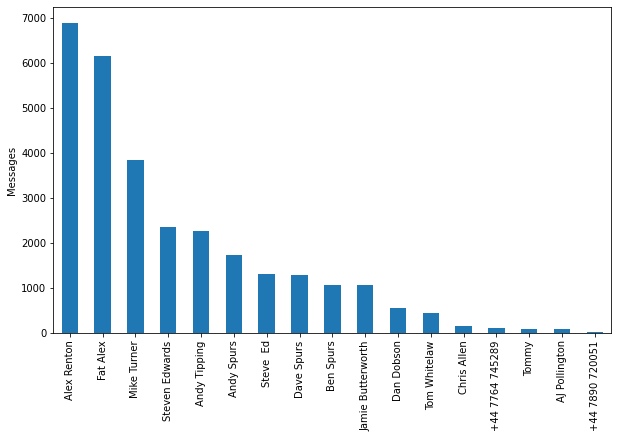

In [170]:
# Plot people with most messages
plt.figure(figsize=(10,6))
df['person'].value_counts().plot.bar()
plt.ylabel('Messages')
plt.show()

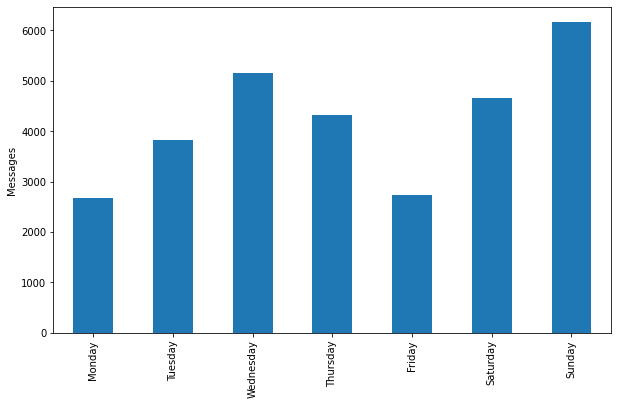

In [171]:
# Plot meesages on each day

# Days column in readable form
days_dict = {
0 : 'Monday',
1 : 'Tuesday',
2 : 'Wednesday',
3 : 'Thursday',
4 : 'Friday',
5 : 'Saturday',
6 : 'Sunday'
}
df['day'] = df['date_time'].dt.weekday.map(days_dict)

# Arrange days order
days = df['day'].value_counts()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days = days.reindex(days_order)

# Plot days
plt.figure(figsize=(10,6))
plt.ylabel('Messages')
days.plot.bar()
plt.show()

In [172]:
# Plot messages by datetime
date_df = df.groupby('date_time').count().reset_index(drop=False)
px.line(date_df, x=date_df['date_time'], y=date_df['message'])

In [173]:
# There are six months of missing data between 24/1/2018 and 19/7/2018

missing_data = df[(df['date_time'].dt.year == 2018) & (df['date_time'].dt.month < 8)]
missing_data.groupby('date', sort=False).count()

,time,person,message,date_time,characters,words,url_count,media_count,day
date,,,,,,,,,
02/01/2018,17,17,17,17,17,17,17,17,17
04/01/2018,17,17,17,17,17,17,17,17,17
05/01/2018,2,2,2,2,2,2,2,2,2
07/01/2018,6,6,6,6,6,6,6,6,6
08/01/2018,3,3,3,3,3,3,3,3,3
10/01/2018,1,1,1,1,1,1,1,1,1
12/01/2018,32,32,32,32,32,32,32,32,32
13/01/2018,5,5,5,5,5,5,5,5,5
14/01/2018,1,1,1,1,1,1,1,1,1


In [174]:
# Label with readable month and year 
df['year'] = df['date_time'].dt.strftime('%Y')
df['month_number'] = df['date_time'].dt.month
months = {
     1 : 'Jan',
     2 : 'Feb',
     3 : 'Mar',
     4 : 'Apr',
     5 : 'May',
     6 : 'Jun',
     7 : 'Jul',
     8 : 'Aug',
     9 : 'Sep',
    10 : 'Oct',
    11 : 'Nov',
    12 : 'Dec'
}
df['month'] = df['month_number'].map(months)
df.drop('month_number',axis=1,inplace=True)
df['month_year'] = df['month'] + ' ' + df['year']

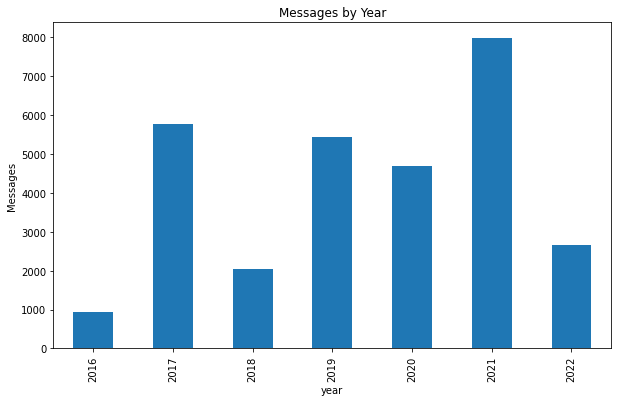

In [175]:
# Plot messages per year
year_df = df.groupby('year').count()['message']

plt.figure(figsize=(10,6))
plt.ylabel('Messages')
plt.title('Messages by Year')
year_df.plot.bar()
plt.show()


In [176]:
month_df = df.groupby('month_year', sort=False).count().reset_index(drop=False)
px.line(month_df, x=month_df['month_year'], y=month_df['message'])

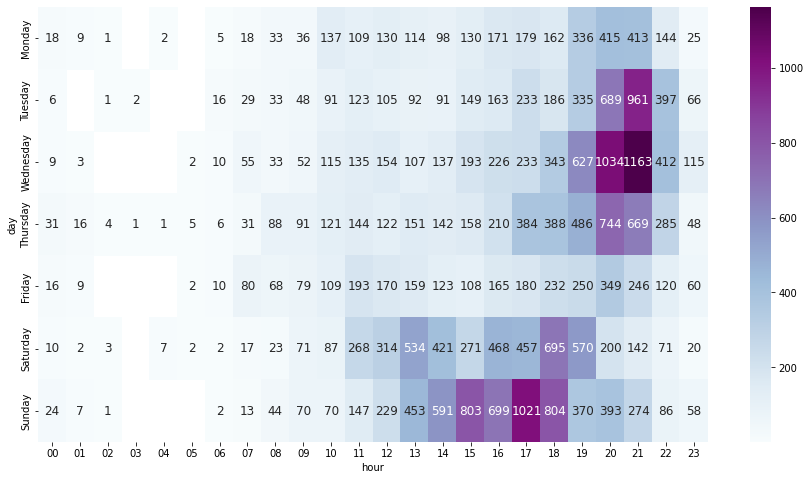

In [177]:
# Plot heatmap of days vs hour with value of total messages

# Hours column 
df['hour'] = df['time'].apply(lambda x : x.split(':')[0])

# Rectangular array needed for heatmap
heat_df = df.pivot_table(index='day', columns='hour', values='message', aggfunc='count')
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heat_df = heat_df.reindex(days_order)

# Plot heatmap
plt.figure(figsize=(15,8))
heatmap(
    data=heat_df,
    cmap="BuPu",
    annot=True, fmt=".0f", annot_kws={"size":12}
    )
plt.show()

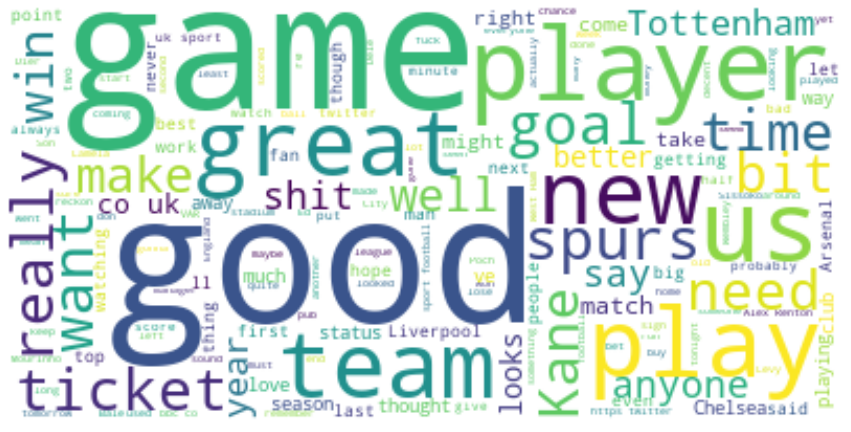

In [178]:
# Create a Word Cloud

# Exclude common words that provide no insight
# STOPWORDS are provided by the WordCloud library
# Add additional STOPWORDS relevant to these data
word_cloud_df = df[df['media_count'] == 0]
exclude_words = {'one', 'got', 'will', 'go', 'going', 'think', 'day', 'now', 'know', 'see', 'back', 'today', 'still', 'look', 'Smith', 'Jez', 'Trav'}
STOPWORDS.update(exclude_words)

# Join all messages into a single string called 'text' and generate WordCloud
text = ''.join(msg for msg in word_cloud_df.message)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(text)

# Plot
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# The word cloud seems to show very common words are the most predominent 

In [179]:
# Create a sentiment analysis on each message using the NLTK VADER analyser
try:
  sid = SentimentIntensityAnalyzer()
except LookupError:
  import nltk
  nltk.download('vader_lexicon')
  sid = SentimentIntensityAnalyzer()

df['nltk_compound'] = df['message'].apply(lambda x:sid.polarity_scores(x)['compound'])
df['nltk_positive'] = df['message'].apply(lambda x:sid.polarity_scores(x)['pos'])
df['nltk_negative'] = df['message'].apply(lambda x:sid.polarity_scores(x)['neg'])
df['nltk_neutral'] = df['message'].apply(lambda x:sid.polarity_scores(x)['neu'])


In [181]:
# Compare the sentiment scores across people
df.groupby('person').mean()

,characters,words,url_count,media_count,nltk_compound,nltk_positive,nltk_negative,nltk_neutral
person,,,,,,,,
AJ Pollington,73.837209,13.453488,0.000000,0.104651,0.072520,0.113919,0.094558,0.791547
Alex Renton,40.028410,7.066676,0.005073,0.046094,0.042527,0.123238,0.087370,0.763301
Andy Spurs,45.510920,7.573563,0.000000,0.076437,0.136765,0.171224,0.050787,0.768798
Andy Tipping,85.416336,13.963355,0.021634,0.071082,0.138477,0.151275,0.064112,0.764299
Ben Spurs,58.660764,10.328984,0.002796,0.089469,0.076313,0.121322,0.061694,0.808596
Chris Allen,55.401235,10.876543,0.006173,0.098765,0.111512,0.120383,0.020247,0.853198
Dan Dobson,61.471930,10.508772,0.022807,0.108772,0.113334,0.125505,0.046516,0.784123
Dave Spurs,38.264957,7.149961,0.000000,0.057498,0.055344,0.113040,0.061737,0.812016
Fat Alex,56.831897,9.690457,0.027150,0.062754,0.095106,0.134954,0.068832,0.777193


In [182]:
people = df.person.unique()
for person in people:
  print(person.upper())
  average_sentiment_scores(df[df['person'] == person])
  print('-------------')

ALEX RENTON
Sentiment: Neutral
	compound: 4.3%
	positive: 12.3%
	negative: 8.7%
	neutral:  76.3%
-------------
ANDY SPURS
Sentiment: Positive
	compound: 13.7%
	positive: 17.1%
	negative: 5.1%
	neutral:  76.9%
-------------
FAT ALEX
Sentiment: Positive
	compound: 9.5%
	positive: 13.5%
	negative: 6.9%
	neutral:  77.7%
-------------
ANDY TIPPING
Sentiment: Positive
	compound: 13.8%
	positive: 15.1%
	negative: 6.4%
	neutral:  76.4%
-------------
CHRIS ALLEN
Sentiment: Positive
	compound: 11.2%
	positive: 12.0%
	negative: 2.0%
	neutral:  85.3%
-------------
TOMMY
Sentiment: Positive
	compound: 10.1%
	positive: 10.4%
	negative: 3.6%
	neutral:  86.0%
-------------
BEN SPURS
Sentiment: Positive
	compound: 7.6%
	positive: 12.1%
	negative: 6.2%
	neutral:  80.9%
-------------
DAVE SPURS
Sentiment: Positive
	compound: 5.5%
	positive: 11.3%
	negative: 6.2%
	neutral:  81.2%
-------------
AJ POLLINGTON
Sentiment: Positive
	compound: 7.3%
	positive: 11.4%
	negative: 9.5%
	neutral:  79.2%
-------------

In [183]:
# Plot sentiment across all years 
temp_df = df.groupby('year', sort=False).mean().reset_index(drop=False)
px.bar(temp_df, x=temp_df['year'], y=temp_df['nltk_compound'])

In [184]:
# Plot how people's sentiment changes over time 
temp_df = df.pivot_table('nltk_compound', 'year', 'person', aggfunc='mean').reset_index(drop=False)
people = df.person.unique()
temp_df = pd.melt(temp_df, id_vars=['year'], value_vars=people)
temp_df.columns = ['year', 'person', 'sentiment']
px.line(temp_df, x='year', y='sentiment', color='person')

In [185]:
px.box(df, x='person', y='nltk_compound')

# Unclear why all box plots have a medium = 0. Seems wrong. 